In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
![kaggle1.png](attachment:kaggle1.png)
![kaggle2.png](attachment:kaggle2.png)
2. Scroll down to API and click Create New API Token.
![kaggle3.png](attachment:kaggle3.png)
![kaggle4.png](attachment:kaggle4.png)
3. Open up `kaggle.json` and use the username and key.
![kaggle5.png](attachment:kaggle5.png)

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached bokeh-2.0.1.tar.gz (8.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached graphviz-0.8.4-py2.py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.3 MB/s eta 0:00:00
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080016 sha256=abaf9c73c5c9db2617d4812d9f97ed08d34118352d42a2cc8989b6173ba2853c
  Stored in directory: /root/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

### Setup Kaggle API Key

In [1]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "ghousiya"
kaggle_key = "862a95321ed9432dff0128e5c1aa70eb"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [3]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand


  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 79.9MB/s]


In [4]:
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
print(train.info())
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [8]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset.
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [10]:
# Print column names
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [11]:
 label = 'count'

In [12]:
ignore_col = ['casual', 'registered']
predictor = TabularPredictor(label=label, problem_type='regression', eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual', 'registered']})
predictor.fit(train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_125324"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_125324/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 207 seconds

### Review AutoGluon's training run with ranking of models that did the best.

In [13]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.134354  root_mean_squared_error      22.739736  405.454204                0.004513           0.075777            3       True         11
1   RandomForestMSE_BAG_L2  -53.396162  root_mean_squared_error      17.636763  292.016037                0.994419          44.678091            2       True         10
2          LightGBM_BAG_L2  -55.170618  root_mean_squared_error      16.888397  281.991132                0.246053          34.653186            2       True          9
3        LightGBMXT_BAG_L2  -60.624321  root_mean_squared_error      21.494752  326.047150                4.852407          78.709204            2       True          8
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.067901    0.063280   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -131.24953866064834,
  'WeightedEnsemble_L2': -84.12506123181602,
  'LightGBMXT_BAG_L2': -60.624320871444205,
  'LightGBM_BAG_L2': -55.17061

### Create predictions from test dataset

In [14]:
predictions = predictor.predict(test)
predictions.head()

0    23.734463
1    43.847195
2    46.753464
3    49.736534
4    51.841080
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [15]:
# Describe the `predictions` series to see if there are any negative values
print(predictions.describe())


count    6493.000000
mean      100.556580
std        89.870224
min         3.319319
25%        20.008373
50%        63.208504
75%       167.947998
max       366.471863
Name: count, dtype: float64


In [16]:
# How many negative values do we have?
num_negatives = (predictions < 0).sum()
print("Number of negative values:", num_negatives)


Number of negative values: 0


In [17]:
# Set them to zero
predictions[predictions < 0] = 0
#print number of negative values after setting to zero
print((predictions < 0).sum())

0


In [18]:
#print evaluation metrics
predictor.evaluate(train)

{'root_mean_squared_error': -76.65073513102125,
 'mean_squared_error': -5875.335196125975,
 'mean_absolute_error': -52.13920827049248,
 'r2': 0.8209301531662975,
 'pearsonr': 0.9401601214532636,
 'median_absolute_error': -30.523361206054688}

### Set predictions to submission dataframe, save, and submit

In [21]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [22]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 736kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [23]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-05-12 13:11:07  first raw submission               complete  1.80276      1.80276       
submission.csv               2024-05-12 12:40:04  first raw submission               complete  1.80376      1.80376       
submission_new_hpo.csv       2024-05-11 21:37:28  new features with hyperparameters  complete  0.48923      0.48923       
submission_new_hpo.csv       2024-05-11 21:28:59  new features with hyperparameters  complete  0.49458      0.49458       


#### Initial score is 1.80276

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

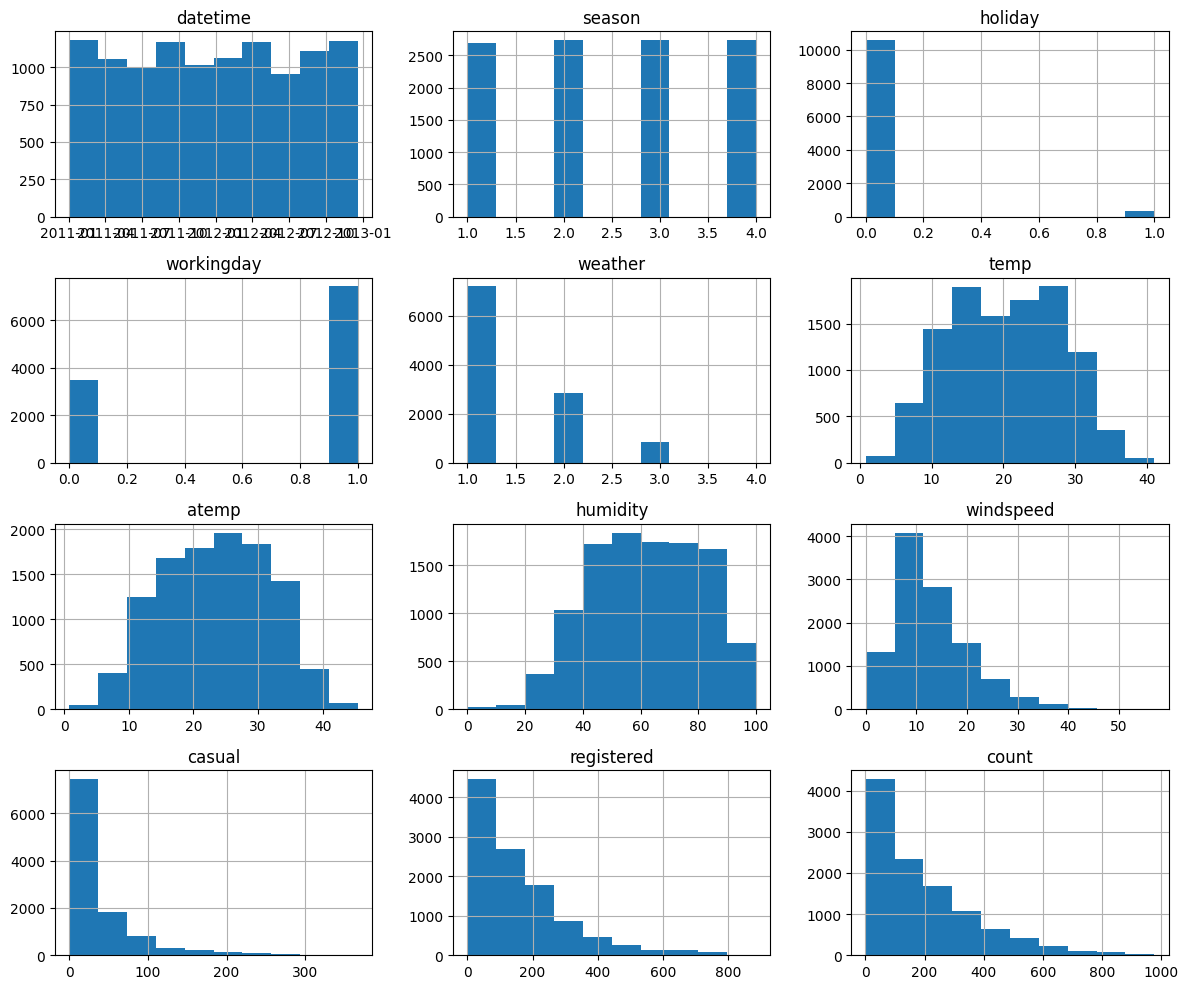

In [24]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
import matplotlib.pyplot as plt
train.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


In [25]:
# create a new feature
# Extract hour, day, and month parts from 'datetime
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

In [26]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


In [27]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [28]:
train['hour'] = train['hour'].astype('category')
train['day'] = train['day'].astype('category')
train['month'] = train['month'].astype('category')
test['hour'] = test['hour'].astype('category')
test['day'] = test['day'].astype('category')
test['month'] = test['month'].astype('category')
print(train.head())

             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count hour day month  
0        81        0.0       3          13     16    0   1     1  
1        80        0.0       8          32     40    1   1     1  
2        80        0.0       5          27     32    2   1     1  
3        75        0.0       3          10     13    3   1     1  
4        75        0.0       0           1      1    4   1     1  


In [29]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,20,1
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,20,1
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,20,1
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,20,1


In [30]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [31]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


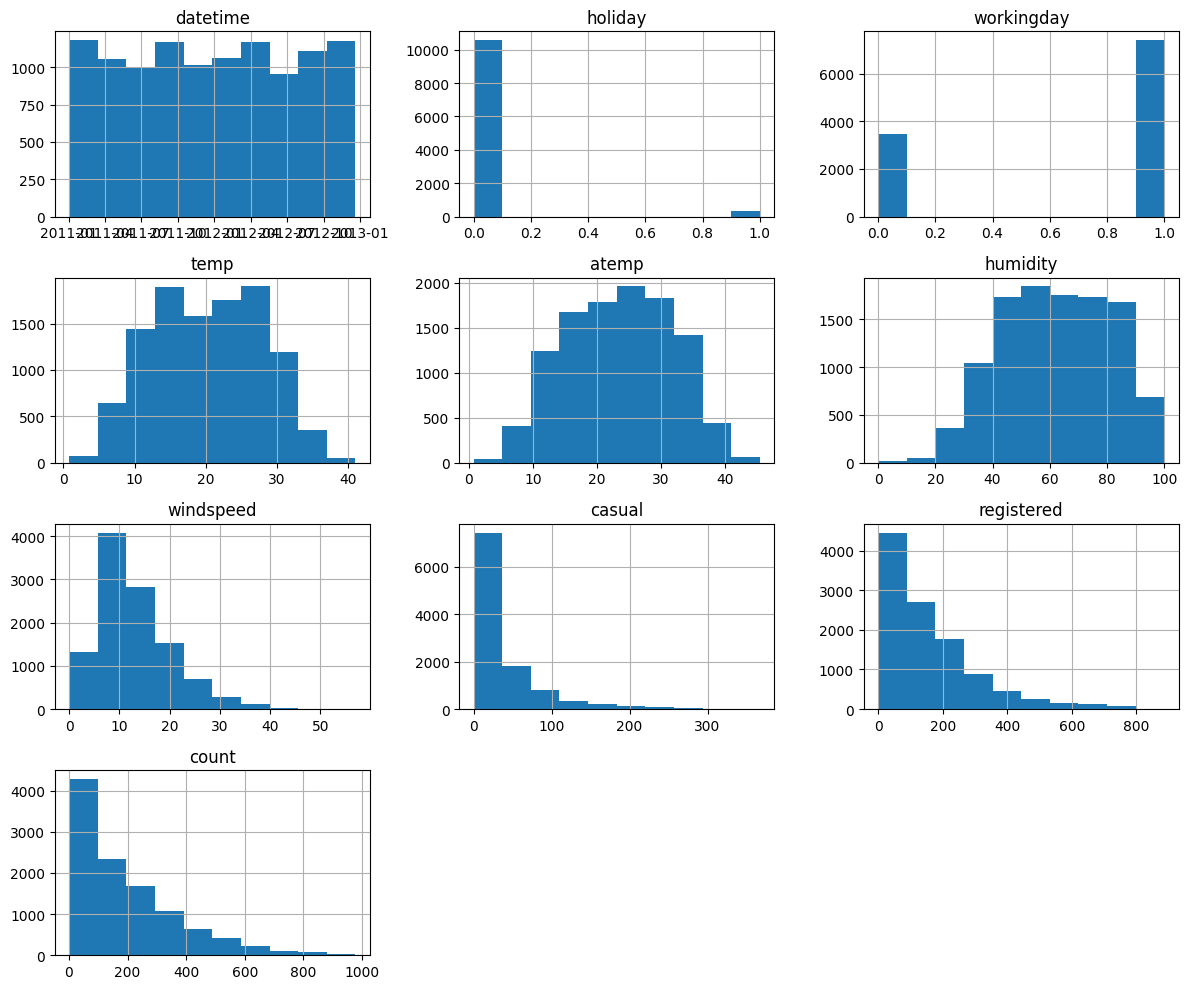

In [32]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [33]:
predictor_new_features = TabularPredictor(label=label,
                                          problem_type='regression',
                                          eval_metric='root_mean_squared_error',
                                          learner_kwargs={'ignored_columns': ['casual', 'registered']})
predictor_new_features.fit(train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_131139"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_131139/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 192 seconds

In [34]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.546908  root_mean_squared_error      27.953758  392.182166                0.001194           0.033673            3       True         11
1          LightGBM_BAG_L2  -30.936673  root_mean_squared_error      26.004407  294.436422                0.618741          38.447508            2       True          9
2        LightGBMXT_BAG_L2  -31.124899  root_mean_squared_error      26.614075  300.476696                1.228408          44.487782            2       True          8
3   RandomForestMSE_BAG_L2  -32.619356  root_mean_squared_error      26.105416  309.213203                0.719749          53.224289            2       True         10
4      WeightedEnsemble_L2  -33.417717  root_mean_squared_error      25.070094  195.617405   

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.97086299575741,
  'LightGBM_BAG_L1': -35.27352311072478,
  'RandomForestMSE_BAG_L1': -38.380301930880755,
  'CatBoost_BAG_L1': -45.795510484242385,
  'WeightedEnsemble_L2': -33.41771675166586,
  'LightGBMXT_BAG_L2': -31.124899395922,
  'LightGBM_BAG_L2': -30.93667255

In [35]:
predictions = predictor_new_features.predict(test)

In [36]:
# Remember to set all negative values to zero
predictions[predictions < 0] = 0
print((predictions < 0).sum())

0


In [37]:
predictor_new_features.evaluate(train)

{'root_mean_squared_error': -19.79114337823117,
 'mean_squared_error': -391.6893562177035,
 'mean_absolute_error': -12.443027254858592,
 'r2': 0.9880619997527045,
 'pearsonr': 0.9955233593013835,
 'median_absolute_error': -7.327329635620117}

In [39]:
predictions.describe()

count    6493.000000
mean      156.476700
std       134.280975
min         1.077255
25%        53.138695
50%       122.020996
75%       221.583160
max       781.063843
Name: count, dtype: float64

In [40]:
# Same submitting predictions
submission["count"] = predictions
submission.to_csv("submission_new_features.csv", index=False)

In [41]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 188k/188k [00:00<00:00, 646kB/s]
Successfully submitted to Bike Sharing Demand

In [43]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-12 13:26:06  new features                       complete  0.70335      0.70335       
submission.csv               2024-05-12 13:11:07  first raw submission               complete  1.80276      1.80276       
submission.csv               2024-05-12 12:40:04  first raw submission               complete  1.80376      1.80376       
submission_new_hpo.csv       2024-05-11 21:37:28  new features with hyperparameters  complete  0.48923      0.48923       


#### New Score of new features is 0.703

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [55]:
from autogluon.common import space
## From autogluon documentation

# Neural Network model
nn_options = {
    'num_epochs': 10,
    'learning_rate': space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': space.Categorical([100], [1000], [200, 100], [300, 200, 100]),
    'dropout_prob': space.Real(0.0, 0.5, default=0.1),
}

# Gradient Boost Model
gbm_options = {
    'num_boost_round': 500,
    'num_leaves': space.Int(lower=26, upper=66, default=36),
}

hyperparameters = {
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,
                  }

num_trials = 2

hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': 'auto',
}

predictor_new_hpo = TabularPredictor(
    label="count",
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
    eval_metric="root_mean_squared_error",
    problem_type="regression")

No path specified. Models will be saved in: "AutogluonModels/ag-20240512_132951"


In [56]:
# Fit the predictor with hyperparameter optimization
predictor_new_hpo.fit(train_data=train, time_limit=600, presets='best_quality', hyperparameters=hyperparameters,
hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240512_132951/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 87 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 

  0%|          | 0/2 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.07%)
Fitted model: LightGBM_BAG_L1/T1 ...
	-36.1493	 = Validation score   (-root_mean_squared_error)
	43.32s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-35.1693	 = Validation score   (-root_mean_squared_error)
	43.08s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 153.78s of the 426.15s of remaining time.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/trainer/abstract_trainer.py", line 2222, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_

  0%|          | 0/2 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.25%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
Fitted model: LightGBM_BAG_L2/T1 ...
	-35.6508	 = Validation score   (-root_mean_squared_error)
	41.55s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-35.9039	 = Validation score   (-root_mean_squared_error)
	36.47s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 190.48s of the 344.75s of remaining time.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/trainer/abstract_trainer.py", line 2222, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/usr/local/lib/python3.10/dist-packages/autogluon/core/models/abstract/abstract_

In [57]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3 -35.001290  root_mean_squared_error       0.003485  127.976210                0.001246           0.030965            3       True          6
1  WeightedEnsemble_L2 -35.064446  root_mean_squared_error       0.004604   86.683899                0.002540           0.285545            2       True          3
2   LightGBM_BAG_L1/T2 -35.169288  root_mean_squared_error       0.001894   43.077526                0.001894          43.077526            1       True          2
3   LightGBM_BAG_L2/T1 -35.650769  root_mean_squared_error       0.002238  127.945245                0.000174          41.546891            2       True          4
4   LightGBM_BAG_L2/T2 -35.903928  root_mean_squared_error       0.002223  122.873204                0.000159         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -36.149338615982344,
  'LightGBM_BAG_L1/T2': -35.169288216673735,
  'WeightedEnsemble_L2': -35.06444609608601,
  'LightGBM_BAG_L2/T1': -35.65076876815447,
  'LightGBM_BAG_L2/T2': -35.903928147920304,
  'WeightedEnsemble_L3': -35.00128980125584},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBM_BAG_L1/T1': ['LightGBM_BAG_L1', 'T1'],
  'LightGBM_BAG_L1/T2': ['LightGBM_BAG_L1', 'T2'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'LightGBM_BAG_L2/T1': ['LightGBM_BAG_L2', 'T1'],
  'LightGBM_BAG_L2/T2': ['LightGBM_BAG_L2', 'T2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'Light

In [58]:
predictions = predictor_new_hpo.predict(test)


In [59]:
# Remember to set all negative values to zero
predictions[predictions < 0] = 0
predictions.describe()

count    6493.000000
mean      192.312332
std       175.366440
min         0.000000
25%        46.751030
50%       150.793671
75%       283.691467
max       891.374695
Name: count, dtype: float64

In [60]:
# Same submitting predictions
submission["count"] = predictions
submission.to_csv("submission_new_hpo.csv", index=False)


In [61]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 188k/188k [00:00<00:00, 649kB/s]  
Successfully submitted to Bike Sharing Demand

In [62]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-05-12 13:34:47  new features with hyperparameters  complete  0.49091      0.49091       
submission_new_features.csv  2024-05-12 13:26:06  new features                       complete  0.70335      0.70335       
submission.csv               2024-05-12 13:11:07  first raw submission               complete  1.80276      1.80276       
submission.csv               2024-05-12 12:40:04  first raw submission               complete  1.80376      1.80376       


In [63]:
predictor_new_hpo.evaluate(train)

{'root_mean_squared_error': -18.588276229115422,
 'mean_squared_error': -345.52401316989744,
 'mean_absolute_error': -12.810417683613382,
 'r2': 0.9894690379271472,
 'pearsonr': 0.9947917265958812,
 'median_absolute_error': -8.617599487304688}

#### New Score of `Hyper parameter optimizarion is 0.49

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

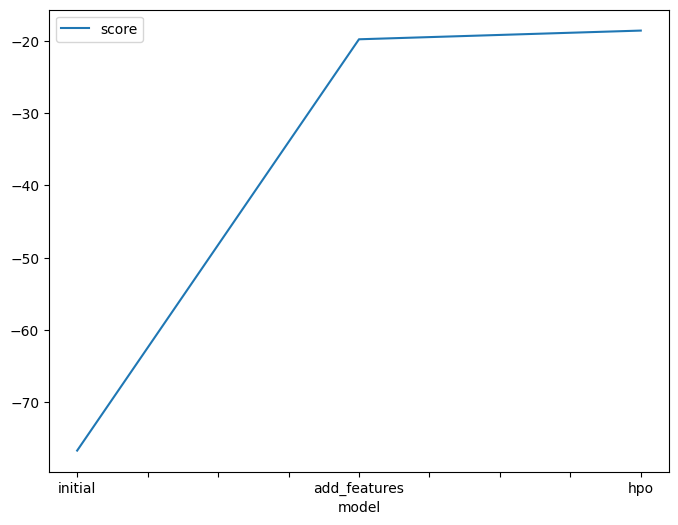

In [65]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-76.650735131021252, -19.791143378231176, -18.588276229115422]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

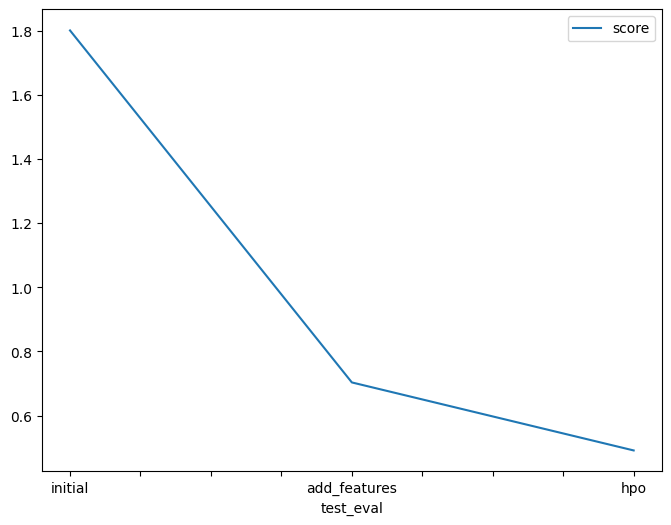

In [66]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80276, 0.70335, 0.49091]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [67]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", "GBM:'num_boost_round': 100,'num_leaves'(lower=26, upper=66, default=36)"],
    "hpo2": ["default", "default", "NN_TORCH (num_epochs': 10), activation('relu', 'softrelu', 'tanh'), dropout:(0.0, 0.5, default=0.1)"],
    "hpo3": ["default", "default", "search_strategy: 'auto', num_trials: 2, scheduler: local"],
    "score": [1.80276, 0.70335, 0.49091]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.80276
1,add_features,default,default,default,0.70335
2,hpo,"GBM:'num_boost_round': 100,'num_leaves'(lower=...","NN_TORCH (num_epochs': 10), activation('relu',...","search_strategy: 'auto', num_trials: 2, schedu...",0.49091
